In [1]:
import pdb
import sys
from scipy.io import readsav
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append("..")

'''from pseudospectrumwrapper import PseudoSpectrumWrapper
from pseudospectrum import PseudoSpectrum
from pseudospectrumplots import PseudoSpectrumPlots
'''
from toolbox import Toolbox

from power_spec_tools import *

dtor=0.017453292

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
def get_kmap_idl(dims, pixsize_arcsec):

    kx = np.arange(dims[0] // 2 + 1) / ((pixsize_arcsec * dims[0] * np.pi / 10800. / 60.)) * 2. * np.pi
    kx = np.concatenate((kx, -kx[1:((1 + dims[0]) // 2)][::-1]))

    ky = np.arange(dims[1] // 2 + 1) / ((pixsize_arcsec * dims[1] * np.pi / 10800. / 60.)) * 2. * np.pi
    ky = np.concatenate((ky, -ky[1:((1 + dims[1]) // 2)][::-1]))

    lx = len(kx)
    ly = len(ky)
    kx = (np.ones((ly, lx)) * kx)
    ky = (np.ones((lx, ly)) * ky).T
    k = np.sqrt(kx ** 2 + ky ** 2)
    return k.T

In [3]:
def get_kmap_yt(dims, pixsize_arcsec):
    lx = np.fft.fftfreq(dims[0]) * 2
    ly = np.fft.fftfreq(dims[1]) * 2
    lx = np.fft.ifftshift(lx) * (180 * 3600. / pixsize_arcsec)
    ly = np.fft.ifftshift(ly) * (180 * 3600. / pixsize_arcsec)
    ly, lx = np.meshgrid(ly, lx)
    l2d = np.sqrt(lx ** 2 + ly ** 2)
    return l2d

In [4]:
def get_twod_fft_idl(map_one, map_two=None, pix_arcsec=False):
    dims = np.shape(map_one)
    if pix_arcsec:
        fac = (pix_arcsec / 3600 * (np.pi / 180)) ** 2 * (dims[0] * dims[1])
    else:
        fac = 1
    if map_two is None:
        return np.real(np.fft.fft2(map_one) * np.conj(np.fft.fft2(map_one))) * fac
    else:
        return np.real(np.fft.fft2(map_one) * np.conj(np.fft.fft2(map_two))) * fac

In [40]:
def get_twod_fft_test(map_one, map_two=None, pix_arcsec=False):
    if map_two is None:
        map_two = map_one.copy()

    dimx, dimy = map_one.shape
    if pix_arcsec:
        sterad_per_pix = (pix_arcsec / 3600 / 180 * np.pi) ** 2
        V = dimx * dimy * sterad_per_pix

        ffta = np.fft.fftn(map_one * sterad_per_pix)
        fftb = np.fft.fftn(map_two * sterad_per_pix)
        ps2d = np.real(ffta * np.conj(fftb)) / V
        ps2d = np.fft.ifftshift(ps2d)
    else:
        V = dimx * dimy

        ffta = np.fft.fftn(map_one)
        fftb = np.fft.fftn(map_two)
        ps2d = np.real(ffta * np.conj(fftb)) #/ V
        #ps2d = np.fft.ifftshift(ps2d)
        ps2d = Toolbox.shift_twod(ps2d,dimx/2,dimy/2)

    return ps2d

In [6]:
name='PSW'
deltal=120
width=0.95

In [7]:
hipe_8_11_calibration_correction=np.array([1.0253,1.0250,1.0125])
spire_color_correction=np.array([1.0213158,1.0100951,1.0252420])
spire_solid_angle=np.array([459.22,796.98,1649.72])/3600.**2.*(np.pi/180.)**2.

In [8]:
path_spt_maps = os.path.join(os.environ['MAPSPATH'],'Herschel','SPT')

spt_maps = {'combined':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_PLW'
             }, 
             'jk1':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half1_PLW'
             }, 
             'jk2':
             {'PSW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PSW',
              'PMW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PMW',
              'PLW':'spt_zea_itermap_10_iterations_15_arcsec_pixels_jk_half2_PLW'
             }, 
            }

In [9]:
class MapObject():
    maps={}
    masks={}
    headers={}
    pix_sizes_arcsec={}
    def __init__(self, base_path, jack_dict):
        for jack, map_dict in jack_dict.items():
            self.maps[jack]={}
            self.masks[jack]={}
            self.headers[jack]={}
            self.pix_sizes_arcsec[jack]={}
            for key, map_name in map_dict.items():
                map_path = os.path.join(base_path, map_name+'.fits')
                try:
                    map_in, hd_in = fits.getdata(map_path, 0, header=True)
                except:
                    map_in, hd_in = fits.getdata(map_path, 1, header=True)
                try:
                    pix_arcsec = hd_in['CDELT2']*3600
                except:
                    pix_arcsec = hd_in['CD2_2']*3600  
                self.maps[jack][key] = map_in
                self.headers[jack][key] = hd_in
                self.pix_sizes_arcsec[jack][key] = pix_arcsec

                mask_in=np.ones_like(map_in)
                mask_in[np.isnan(map_in)]=0
                map_in[np.isnan(map_in)]=0
                self.masks[jack][key] = mask_in

In [10]:
maps_obj = MapObject(path_spt_maps, spt_maps)

In [12]:
psw = maps_obj.maps['combined'][name]
psw_mask = maps_obj.masks['combined'][name]
psw_mask_jk1 = maps_obj.masks['jk1'][name]
psw_mask_jk2 = maps_obj.masks['jk2'][name]

In [13]:
psw_hd = maps_obj.headers['combined'][name]

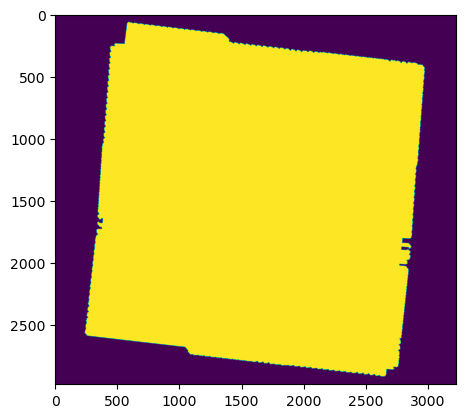

In [15]:
plt.imshow(psw_mask);

In [16]:
pix_psw = maps_obj.pix_sizes_arcsec['combined']['PSW']

In [17]:
def get_ell_bins(mapin, pix_arcsec, deltal=None, width=0, lmin=0, k_theta=False):
    if not deltal:
        shape_mapin = np.shape(mapin)
        xx = shape_mapin[0]
        yy = shape_mapin[1]
        eff_side = np.sqrt(xx * yy)
        #eff_side = yy
        print('sqrt(xx*yy) = {}, xx={}, yy={}'.format(np.sqrt(xx * yy), xx, yy))
        eff_a = eff_side * (pix_arcsec / 3600.) * dtor
        deltal = 2. * np.pi / eff_a
        print('deltal is {}'.format(deltal))

    if not width:
        dims = np.shape(mapin)
        kmap = self.get_kmap(dims, pix_arcsec)
        nk = int(np.floor(np.max(kmap) / deltal))
        ell = np.arange(nk) * deltal + deltal / 2 + lmin
    else:
        ell = linloggen(deltal=deltal, width=width)

    k_theta_log = Toolbox.ell_to_k(ell)
    if k_theta:
        return k_theta_log
    else:
        return ell

In [18]:
def linloggen(deltal, width, minval=None, maxval=None, ltrans=None, verbose=False):

    if not minval:
        minval = deltal / 2.
    if not maxval:
        maxval = Toolbox.k_to_ell(4.)
    if verbose:
        print('minval={0:0.1f}'.format(minval))
        print('maxval={0:0.1f}'.format(maxval))
    nlin = int(np.floor(1. / width))
    if verbose:
        print('nlin={0:0.1f}'.format(nlin))
    ltrans = nlin * deltal + minval
    if verbose:
        print('ltrans={0:0.1f}'.format(ltrans))

    npoints = 2 * np.log10(maxval / ltrans) / width
    if verbose:
        print('npoints={0:0.3f}'.format(npoints))

    points = np.arange(np.floor(npoints)) / (npoints)
    if verbose:
        print('len(points)={0:0.3f}'.format(len(points)))

    n = int(np.floor(npoints + nlin))
    if verbose:
        print('n={0:0.3f}'.format(n))

    ell = np.zeros(n)
    ell[:nlin] = np.arange(nlin) * deltal + minval
    ell[nlin:] = 10 ** ((np.log10(maxval / ltrans)) * points + np.log10(ltrans))

    return ell

In [19]:
def bin_in_rings(mapin, ell_bins, kmap, kpower=0):
    pk = np.zeros_like(ell_bins[:-1])
    deltal = np.diff(ell_bins)
    ell = ell_bins[:-1] + deltal / 2.
    ind_log = deltal > deltal[0]
    ell[ind_log] = np.sqrt(ell_bins[:-1] * ell_bins[1:])[ind_log]
    for i in range(len(ell_bins[:-1])):
        ind_ell = (kmap >= ell_bins[i]) & (kmap < ell_bins[i + 1])
        pk[i] = np.mean(mapin[ind_ell] * kmap[ind_ell] ** kpower) / \
                ell[i] ** kpower
        #ell[i] = np.mean(kmap[ind_ell])
    return pk, ell

In [47]:
def get_mc_mkk(mask_one, mask_two, pix_arcsec, deltal=None, width=None, nomask=False):
    shape_map = np.shape(mask_one)
    k_map=get_kmap_yt(shape_map, pix_arcsec)
    k_map_idl=get_kmap_idl(shape_map, pix_arcsec)
    ell_bins = get_ell_bins(mask_one, pix_arcsec, deltal=deltal, width=width)
    npk = len(ell_bins[:-1])
    pk = np.zeros([npk,npk])
    pk_idl = np.zeros([npk,npk])
    #ell = np.zeros_like(pk)
    for iell in range(npk):
        idx_ring = (k_map >= ell_bins[iell]) & (k_map < ell_bins[iell+1])
        idx_not_ring = (k_map < ell_bins[iell]) | (k_map >= ell_bins[iell+1])
        imap_ring = np.ones_like(mask_one)*np.random.normal(size=shape_map)
        imap_ring[idx_not_ring]=0
        
        imode_map = (np.real(np.fft.ifft2(imap_ring))+np.imag(np.fft.ifft2(imap_ring)))
        if nomask:
            imask_mkk = get_twod_fft_test(imode_map, map_two=None, pix_arcsec=None)
            #imask_mkk_idl = get_twod_fft_idl(imode_map, map_two=None, pix_arcsec=None)
        else:
            imask_mkk = get_twod_fft_test(imode_map * mask_one, map_two=imode_map * mask_two, pix_arcsec=None)
            #imask_mkk_idl = get_twod_fft_idl(imode_map * mask_one, map_two=imode_map * mask_two, pix_arcsec=None)
        pdb.set_trace()
        ipk_mask, ipk_ell = bin_in_rings(imask_mkk, ell_bins, k_map)
        ipk_mask_idl, ipk_ell_idl = bin_in_rings(imask_mkk_idl, ell_bins, k_map_idl)
        pk[iell] = ipk_mask
        pk_idl[iell] = ipk_mask_idl
        #ell[iell] = np.mean(k_map[idx_ring])
    #return ell_bins, pk
    return ell_bins, pk #, pk_idl

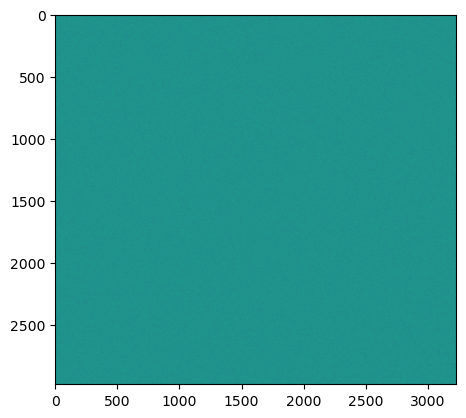

In [55]:
dims = np.shape(psw_mask_jk1)
imap_ring = np.ones_like(psw_mask)*np.random.normal(size=dims)
imode_map = (np.real(np.fft.ifft2(imap_ring))+np.imag(np.fft.ifft2(imap_ring)))
plt.imshow(imode_map);

> c:\users\viero\appdata\local\temp\ipykernel_33224\2176038716.py(24)get_mc_mkk()

ipdb> plt.imshow(imode_map)
ipdb> plt.show()


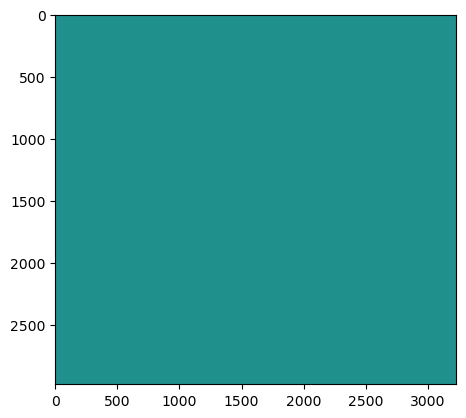

ipdb> exit


In [48]:
#tst_ell, tst_pk, tst_pk_idl = get_mc_mkk(psw_mask_jk1, psw_mask_jk2, pix_psw, deltal=deltal, width=width, nomask=False)
tst_ell, tst_pk = get_mc_mkk(psw_mask_jk1, psw_mask_jk2, pix_psw, deltal=deltal, width=width, nomask=False)

In [36]:
print(deltal)
print(width)
print(tst_ell)

120
0.95
[   60.           180.           537.36887141  1604.25168864
  4789.30510764 14297.90822504]


In [43]:
tst_pk

array([[ 3.41562826e-10,  2.92040835e-10, -4.90364535e-11,
         2.37073435e-11, -7.03209611e-11],
       [ 6.98927475e-09,  2.38207791e-09,  2.69995568e-09,
        -9.45639304e-10,  2.79031593e-10],
       [ 3.18788493e-08,  9.75868705e-09, -9.76142075e-09,
        -5.09024198e-09, -4.26619440e-09],
       [-4.80081338e-08, -2.61309952e-07, -6.88500993e-08,
        -1.63708507e-08,  3.29542988e-08],
       [ 6.22266193e-06,  1.48315086e-06,  7.21138443e-08,
         3.07868694e-07,  2.37898491e-07]])

In [44]:
tst_pk_idl

array([[-4.88051604e-11, -2.49670893e-12,  1.56356859e-10,
        -1.21337104e-10, -6.10289361e-11],
       [-1.81090345e-09,  5.92995436e-11, -1.60060351e-09,
        -1.84992218e-09,  6.46542656e-10],
       [-5.49276500e-09, -6.05792681e-08,  1.80123913e-09,
        -1.43816507e-08, -4.32359328e-09],
       [-3.97083444e-07, -3.64658779e-07, -1.74203518e-07,
        -3.43808137e-08,  5.05604368e-08],
       [ 2.91517004e-06,  1.88531192e-06,  3.90476008e-07,
         2.43864143e-08,  2.18227156e-07]])

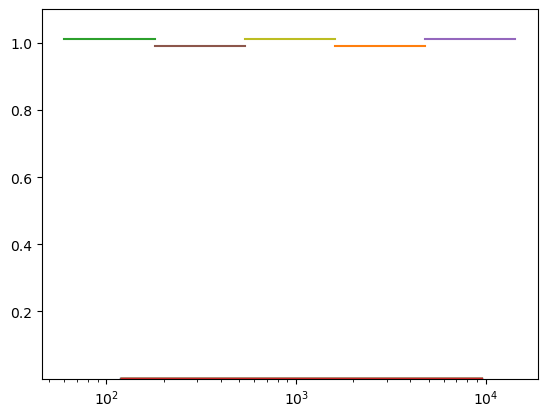

In [39]:
#zero_factor = 1 - (np.sum(hers_mask_jk1==0)+np.sum(hers_mask_jk2==0))/2/np.prod(dims)
fudge_factor = 1 # 1/((pix_arcsec/3600 * (np.pi/180))**2 * (dims[0]*dims[1])) / zero_factor
tst_ell = get_ell_bins(psw_mask, pix_psw, deltal=deltal, width=width)
ell_out = (tst_ell[:-1]+tst_ell[1:])/2
for i in range(len(ell_out)):
    plt.plot(ell_out, fudge_factor*tst_pk[i]);
    plt.plot(ell_out, fudge_factor*tst_pk_idl[i]);
    yh = 1+0.01*(-1)**i
    plt.plot([tst_ell[i],tst_ell[i+1]],[yh,yh])
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlim([25,50000])    
    plt.ylim([1e-8,1.1])

In [36]:
ell_yt, fft_yt = Cl2D_from_map2D(map_a = plw, pixsize=pix_plw)

In [64]:
fft_yt

array([[1.51363912e-10, 1.39699546e-08, 3.60421664e-09, ...,
        2.01110342e-09, 3.60421664e-09, 1.39699546e-08],
       [1.00926141e-08, 8.85984913e-09, 8.47760245e-10, ...,
        6.63033922e-09, 4.25504239e-09, 1.23367178e-08],
       [5.38026141e-09, 4.58857273e-09, 2.05378221e-09, ...,
        1.19036838e-08, 2.93245703e-09, 1.92059684e-08],
       ...,
       [1.50152262e-08, 1.10570189e-08, 7.13513588e-10, ...,
        8.33346477e-09, 1.41425818e-09, 2.38655011e-09],
       [5.38026141e-09, 1.92059684e-08, 2.93245703e-09, ...,
        7.05287622e-09, 2.05378221e-09, 4.58857273e-09],
       [1.00926141e-08, 1.23367178e-08, 4.25504239e-09, ...,
        6.01135645e-09, 8.47760245e-10, 8.85984913e-09]])

In [37]:
fft_idl = get_twod_ifft_idl(plw, pix_arcsec=pix_plw)

In [45]:
fft_idl

array([[2.34155659e-11, 5.27597289e-14, 2.48816100e-12, ...,
        4.19605450e-12, 2.48816100e-12, 5.27597289e-14],
       [6.57312295e-13, 8.15350220e-14, 6.46377002e-12, ...,
        2.46974371e-13, 9.73440674e-13, 4.10899840e-13],
       [2.99620963e-12, 2.21102573e-12, 6.60502121e-13, ...,
        2.45021736e-12, 1.90267153e-12, 8.18189945e-13],
       ...,
       [2.26047381e-12, 2.34836245e-12, 1.55422515e-11, ...,
        1.37678717e-12, 8.78373768e-12, 1.42673481e-12],
       [2.99620963e-12, 8.18189945e-13, 1.90267153e-12, ...,
        2.33079618e-12, 6.60502121e-13, 2.21102573e-12],
       [6.57312295e-13, 4.10899840e-13, 9.73440674e-13, ...,
        1.57986220e-12, 6.46377002e-12, 8.15350220e-14]])

In [60]:
fft_idl_raw = get_twod_fft_idl(plw, pix_arcsec=None)

In [61]:
fft_idl_raw

array([[42534.25343501,    95.83777252,  4519.73149417, ...,
         7622.11112818,  4519.73149417,    95.83777252],
       [ 1194.0043578 ,   148.10794235, 11741.40454239, ...,
          448.62765703,  1768.24990917,   746.39741654],
       [ 5442.59917241,  4016.31671306,  1199.79865976, ...,
         4450.80706568,  3456.19292474,  1486.23777024],
       ...,
       [ 4106.13889484,  4265.78814796, 28232.41878152, ...,
         2500.92671127, 15955.61370257,  2591.65635085],
       [ 5442.59917241,  1486.23777024,  3456.19292474, ...,
         4233.87910499,  1199.79865976,  4016.31671306],
       [ 1194.0043578 ,   746.39741654,  1768.24990917, ...,
         2869.81144295, 11741.40454239,   148.10794235]])

In [124]:
tst_pk


array([[5.39583580e-09, 9.05578959e-09, 1.19406352e-08, 8.56362881e-09,
        1.04950333e-08],
       [5.41667945e-08, 7.39949863e-08, 9.21560229e-08, 8.68916192e-08,
        8.82620650e-08],
       [1.43169183e-06, 1.18042217e-06, 1.00000260e-06, 8.32410464e-07,
        9.28563390e-07],
       [5.20278398e-06, 4.63896691e-06, 5.78106061e-06, 6.26606543e-06,
        6.83063449e-06],
       [5.17016356e-05, 5.30568517e-05, 5.77250133e-05, 6.02872997e-05,
        6.29563004e-05]])

In [125]:
tst_pk_idl

array([[5.39583580e-09, 9.05578959e-09, 1.19406352e-08, 8.56362881e-09,
        1.04950333e-08],
       [5.41667945e-08, 7.39949863e-08, 9.21560229e-08, 8.68916192e-08,
        8.82620650e-08],
       [1.43169183e-06, 1.18042217e-06, 1.00000260e-06, 8.32410464e-07,
        9.28563390e-07],
       [5.20278398e-06, 4.63896691e-06, 5.78106061e-06, 6.26606543e-06,
        6.83063449e-06],
       [5.17016356e-05, 5.30568517e-05, 5.77250133e-05, 6.02872997e-05,
        6.29563004e-05]])